### Teljes bináris fa bejárása

 **Feladat**: Generáljuk le (írjuk ki az ```stdout```-ra) az összes adott $n$ hosszúságú $0-1$ sorozatot!<br>
 
 **Megoldás**: $n$ szint van, minden szinten mindent ($0,1$) végigpróbálunk.<br>
 
 **Implementáció**:

In [13]:
function gen01( hossz; ír=true )
  akt = fill( '_',hossz ) # -> fill
  function bejár( szint )
    if szint > hossz
      ( true == ír ) ? println( join(akt) ) : nothing
      a=szint^2
      return
    end
    akt[ szint ] = '0'
    bejár( 1+szint )
    akt[ szint ] = '1'
    bejár( 1+szint )
  end
end

@time gen01(3,ír=false)(1)


  0.034037 seconds (57.80 k allocations: 2.922 MiB)


A levelekkel együtt $2\cdot(2^{n}-1)$ csúcsot járunk be. <br>

Mérjük meg különböző $n$-ekre a futási időt! Mivel tudjuk, hogy exponenciális 
a futási idő, ezért a mérések logaritmusát ábrázoljuk.

Ha egy k szintes fa egy csúcsát 1sec alatt alatt járná be 
a program, akkor kb. $2^k$sec alatt végezne, ezt az

31553163 csúcsot vizsgál másodpercenként. A használt cpu:
cpu MHz		: 3521.144


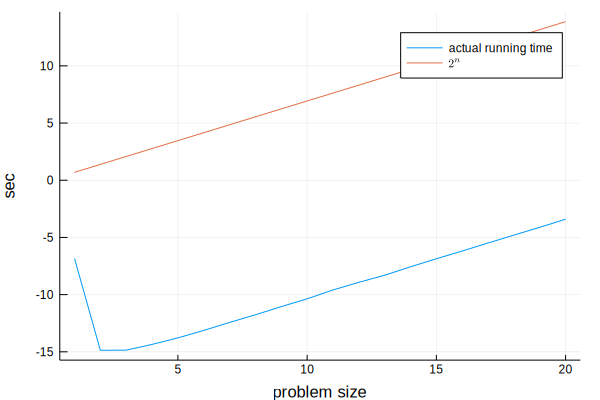

In [15]:
N=20
H=10
idők=zeros(N)
for n=1:N
  t0=time_ns()
  for h=1:H gen01(n,ír=false)(1) end
  idők[n]=(time_ns()-t0)/(H*1e9)
end
println( Int(floor(2^N / idők[N]))," csúcsot vizsgál másodpercenként. A használt cpu:")
run( pipeline(  `cat /proc/cpuinfo`, `grep -m 1 -i mhz` ) );
using Plots, LaTeXStrings # matematikai jelölések használata
plot( 1:N, log.(idők), label="actual running time", ylabel="sec", xlabel="problem size" )
plot!( 1:N, log(2)*(1:N), label=L"2^n" )


Ezt a technikát használhatjuk a [hátizsák-feladat](https://en.wikipedia.org/wiki/Knapsack_problem) megoldására.<br>

### Probléma:<br> 
A következőkben minden adat pozitív egész szám.<br>
Adott $n$ tárgy, $w_1,\cdots,w_n$ súlyokkal és $v_1,\cdots,v_n$ értékekkel.<br> 
Van egy $K$ kapacitású hátizsák, amibe minnél nagyobb *összértékű* részhalmazát akarjuk bepakolni a tárgyaknak. 

### Megoldás:<br> 
Minden olyan részhalmazt megvizsgálunk, ami belefér a zsákba. Brute force.

### Implementáció:<br> 
A gen01-et átalakítása.

In [72]:
function ks(v, w, K) # hátizsák:knapsack
  n=length(w)
  optV=0
  function bejár( szint, aktV, aktW )
    if szint>n
      optV=max(optV, aktV)
      return
    else
      if( aktW+w[szint] <= K )
        bejár( 1+szint, aktV+v[szint], aktW+w[szint] )
      end
      bejár( 1+szint, aktV, aktW )
    end
  end
  bejár(1,0,0)
  optV
end


ks (generic function with 1 method)

Teszteljük le néhány esetre:

In [73]:
# http://www.mafy.lut.fi/study/DiscreteOpt/DYNKNAP.pdf, opt=29
v1 = [ 15,10,9,5 ]
w1 = [ 1,5,3,4 ]
K1 = 8
println( ks( v1, w1, K1 ) )
# https://www.cs.colostate.edu/~cs475/f14/Lectures/Lec4Knapsack.pdf, opt=40
v2 = [ 1,6,18,22,28 ]
w2 = [ 1,2,5,6,7 ]
K2 = 11
println( ks( v2, w2, K2 ) )
# http://www.or.deis.unibo.it/kp/Chapter2.pdf , opt=280
v3 = [ 15,100,90,60,40,15,10,1 ]
w3 = [ 2,20,20,30,40,30,60,10 ]
K3 = 102
println( ks( v3, w3, K3 ) )


29
40
280


Csináljunk egy nagyobb inputot:

In [103]:
v4 = vcat( v1,v2,v3,v1,v2 )
w4 = vcat( w1,w2,w3,w1,w2 )
K = K1+K2+K3+K1+K2
println( "n=", length(v) )
@time println( ks( v4, w4, K ) )


n=26
493
  2.167653 seconds (193 allocations: 10.688 KiB)


Hogyan tudnánk ezt a módszert gyorsítani? <br>
A következő egyszerű technika megtalálható a Pascal nyelv atyja által írt [könyvben](https://moly.hu/konyvek/niklaus-wirth-algoritmusok-adatstrukturak-programok)

In [91]:
function ksV( v, w, K )
  n=length(w)
  optV=0
  function bejár( szint, aktV, aktW, sumV )
    if szint > n
      optV=max( optV, aktV )
      return
    else
      if aktW+w[szint] <= K 
        bejár( 1+szint, aktV+v[szint], aktW+w[szint], sumV )
      end
      sumV -= v[szint];
      if sumV > optV
        bejár( 1+szint, aktV, aktW, sumV )
      end
    end
  end
  bejár(1,0,0,sum(v))
  optV
end  


ksV (generic function with 1 method)

In [109]:
v5=vcat(v4,v3)
w5=vcat(w4,w3)
println( "n=", length(v5) )
@time println( ksV( v5, w5, K ) )

n=34
620
  3.460681 seconds (112.58 M allocations: 1.678 GiB, 9.11% gc time)


Egy másik egyszerű dolgot is kiaknázhatunk,<br>
rendezzük a tárgyakat relatív értékesség szerint $\frac{Ft}{kg}$ :
$$
\frac{v_i}{w_i} \ge \ldots \ge \frac{v_n}{w_n}
$$
Először egyesítjuk az adatokat: vektorokból álló vektort hozunk létre.<br>
Majd megfelelően módosítjuk a ```ksV```t.


In [87]:
data = [ (v[i], w[i]) for i in 1:length(v) ] 
rend(x)=x[1]/x[2]
sort!( data, by=rend, rev=true )

34-element Array{Tuple{Int64,Int64},1}:
 (15, 1)  
 (15, 1)  
 (15, 2)  
 (15, 2)  
 (100, 20)
 (100, 20)
 (90, 20) 
 (90, 20) 
 (28, 7)  
 (28, 7)  
 (22, 6)  
 (22, 6)  
 (18, 5)  
 ⋮        
 (5, 4)   
 (5, 4)   
 (1, 1)   
 (40, 40) 
 (1, 1)   
 (40, 40) 
 (15, 30) 
 (15, 30) 
 (10, 60) 
 (10, 60) 
 (1, 10)  
 (1, 10)  

In [97]:
function ksV2( v, w, K )
  data = [ (v[i], w[i]) for i in 1:length(v) ] 
  sort!( data, by=(x)->x[1]/x[2], rev=true )
  n=length(data)
  for i in 1:n v[i],w[i] = data[i] end
    
  optV=0
  function bejár( szint, aktW, sumV )
    if szint > n
      optV=max( optV, sumV )
      return
    else
      if aktW+w[szint] <= K 
        bejár( 1+szint, aktW+w[szint], sumV )
      end
      sumV -= v[szint]
      if sumV > optV
        bejár( 1+szint, aktW, sumV )
      end
    end
  end
  bejár( 1, 0, sum(v) )
  optV
end  


ksV2 (generic function with 1 method)

In [113]:
println( "n=", length(v5) )
@time println( ksV2( v5, w5, K ) )

n=34
620
  0.367177 seconds (12.71 M allocations: 193.882 MiB, 11.50% gc time)


Látjuk, hogy a vizsgált feladat-példányra gyorsabb megoldást kapunk.<br>

Az igazán fontos dolog:<br>
A **folytonos** hátizsák feladatra a **mohó** algoritmus optimális megoldást ad, <br>
ha a tárgyak relatív értékesség szerint csökkenően rendezettek. Ezt [Dantzig](https://hu.wikipedia.org/wiki/George_Dantzig) fogalmazta meg először.(lásd [itt](https://en.wikipedia.org/wiki/Continuous_knapsack_problem) ) <br> 
Segítségével a még hátralevő targyakra megoldjuk a relaxált feladatot és az így kapott korlátot 
használjuk vágásra.<br>

### Megvalósítás:

In [2]:
function ksV3( v, w, K )
  data = [ (v[i], w[i]) for i in 1:length(v) ] 
  sort!( data, by=(x)->x[1]/x[2], rev=true )
  n=length(data)
  for i in 1:n v[i],w[i] = data[i] end
    
  function D(i,tK) # Dantzig korlát kiszámítása
    o=0.0
    while i<=n && tK>0
      t = min( tK, w[i] )
      tK -= t
      o += t*v[i]/(1.0*w[i])
      i += 1
    end
    Int(floor(o))
  end
  optV=0
  function bejár( szint, aktW, aktV )
    if szint > n
      optV=max( optV, aktV )
      return
    else
      if aktW+w[szint] <= K 
        bejár( 1+szint, aktW+w[szint], aktV+v[szint] )
      end
      if aktV + D( 1+szint, K-aktW ) > optV
        bejár( 1+szint, aktW, aktV )
      end
    end
  end
  bejár( 1, 0, 0 )
  optV
end  


ksV3 (generic function with 1 method)

In [130]:
println( "n=", length(v5) )
@time println( ksV3( v5, w5, K ) )

n=34
890
  0.000041 seconds (109 allocations: 3.109 KiB)


In [137]:
v6 = vcat(v5,v5,v5,v3)
w6 = vcat(w5,w5,w5,w3)
K = K+K
println( "n=", length(v6) )
@time println( ksV3( v6, w6, K ) )

n=110
3001
  0.000241 seconds (305 allocations: 8.422 KiB)


Az $6$-os adattal a ```ksV2``` már nem boldogul emberi időben, a ```ksV3``` viszont ledarálja.<br>


**Fontos** hogy ennél a (rekurzív) módszernél az adatok ($v,w,K$) lehetnek **tört** számok is!<br>

A következő alkalommal megismerkedünk egy **dinamikus programozás**os<br>
(táblázatos, iteratív) megoldással, melynél a $w,K$-nak **egésznek** kell lennie.

In [11]:
# https://developers.google.com/optimization/bin/knapsack, opt=7534
v7 = [360, 83, 59, 130, 431, 67, 230, 52, 93,
            125, 670, 892, 600, 38, 48, 147, 78, 256,
            63, 17, 120, 164, 432, 35, 92, 110, 22,
            42, 50, 323, 514, 28, 87, 73, 78, 15,
            26, 78, 210, 36, 85, 189, 274, 43, 33,
            10, 19, 389, 276, 312]

w7 = [7, 0, 30, 22, 80, 94, 11, 81, 70,
              64, 59, 18, 0, 36, 3, 8, 15, 42,
              9, 0, 42, 47, 52, 32, 26, 48, 55,
              6, 29, 84, 2, 4, 18, 56, 7, 29,
              93, 44, 71, 3, 86, 66, 31, 65, 0,
              79, 20, 65, 52, 13]

tuti = sum( v7[ w7 .== 0 ] ) # a nulla súlyuakat alapból berakja
v7 = v7[ w7 .> 0 ] # és ki is dobálja (v/w értelmetlen 0-ra)
w7 = w7[ w7 .> 0 ]

K = 850
println( "n=", length(v7) )
@time println( tuti + ksV3( v7, w7, K ) )

n=46
7534
  0.000046 seconds (296 allocations: 6.313 KiB)
